***Midday Crime Spikes in Cities***

**Project Objectives**

This analysis identifies when major crimes across Seattle and San Francisco were committed during the Summer 2014 period and outlines the nature of observed midday crime spikes. More details about the project objectives and data set can be found at https://github.com/uwescience/datasci_course_materials/blob/master/assignment6/crimeanalytics.md


**General Approach**

The data from each city was first normalised to facilitate easier comparison. The 5 most prominent crimes for each city was then determined and used as the basis of comparison across the cities. The data was then grouped by city, crime type and time occurence to perform analyses.


**Implementation**

Data Normalisation predominantly involved converting Seattle data to the San Francisco format since the San Francisco format was better broken down by incident time and had fewer crime categories. Category mapping was also performed against the top 10 categories in each city, with ambiguous prominent categories not being mapped on a per-city basis. The top 5 categories were then extracted and grouped by city, crime type and time occurence.


In [5]:
library(tidyverse)
library(ggplot2)

options(repr.plot.width = 9, repr.plot.height = 7)

seattle <- read.csv('../input/seattle_incidents_summer_2014.csv')
sanfrancisco <- read.csv('../input/sanfrancisco_incidents_summer_2014.csv')

weekday_levels <- c('Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday')
normalise_seattle <- function(seattle) {
  date_time <- strptime(as.character(seattle$Occurred.Date.or.Date.Range.Start), format = '%m/%d/%Y %I:%M:%S %p')

  cat <- as.character(seattle$Summarized.Offense.Description)
  # to include as part of modified function
  cat <- ifelse(cat %in% c('BIKE THEFT','CAR PROWL','MAIL THEFT','SHOPLIFTING'), 'LARCENY/THEFT', cat)
  cat <- ifelse(cat %in% 'NARCOTICS', 'DRUG/NARCOTIC', cat)
  cat <- ifelse(cat %in% 'WARRANT ARREST', 'WARRANTS', cat)

  data.frame(
    City = as.character(rep('Seattle', nrow(seattle))),
    DayOfWeek = factor(weekdays(date_time), levels=weekday_levels),
    Hour = as.numeric(date_time$hour),
    Category = cat
  )
}

normalise_sanfrancisco <- function (sanfrancisco) {
  cat <- as.character(sanfrancisco$Category)
  cat <- ifelse(cat %in% 'VANDALISM', 'OTHER PROPERTY', cat)

  data.frame(
    City = as.character(rep('San Francisco', nrow(sanfrancisco))),
    Hour = as.numeric(substring(as.character(sanfrancisco$Time),1,2)),
    DayOfWeek = factor(sanfrancisco$DayOfWeek, levels=weekday_levels),
    Category = cat
  )
}

summarise_data <- function(data) {
  as.data.frame(data %>% group_by(Category) %>% summarise(Incidents = n()))
}

get_large_categories <- function(summarised_data) {
  top_cats <- summarised_data %>% top_n(5, Incidents)
  unique(as.character(top_cats$Category))
}

extract_large_categories <- function(summarised_seattle, summarised_sanfrancisco) {
  cats_seattle <- get_large_categories(summarised_seattle)
  cats_sanfrancisco <- get_large_categories(summarised_sanfrancisco)

  unique(c(cats_seattle, cats_sanfrancisco))
}

normal_seattle <- normalise_seattle(seattle)
normal_sanfrancisco <- normalise_sanfrancisco(sanfrancisco)

summarised_seattle <- summarise_data(normal_seattle)
summarised_sanfrancisco <- summarise_data(normal_sanfrancisco)

filter_cats <- extract_large_categories(summarised_seattle,summarised_sanfrancisco)
result_data <- rbind(normal_seattle, normal_sanfrancisco)
result_data <- result_data[result_data$Category %in% filter_cats,]
result_data$Category = as.factor(as.character(result_data$Category))
result_data$Hour = as.factor(result_data$Hour)

grouped_bar_data <- as.data.frame(result_data %>% group_by(City, DayOfWeek, Hour, Category) %>% summarise(Incidents = n()))

**Analysis**

With a criminal analysis, it's important to understand which crimes are the most prominent and in this case, how do they vary by city. Plotting the bar chart below gives some insight. 

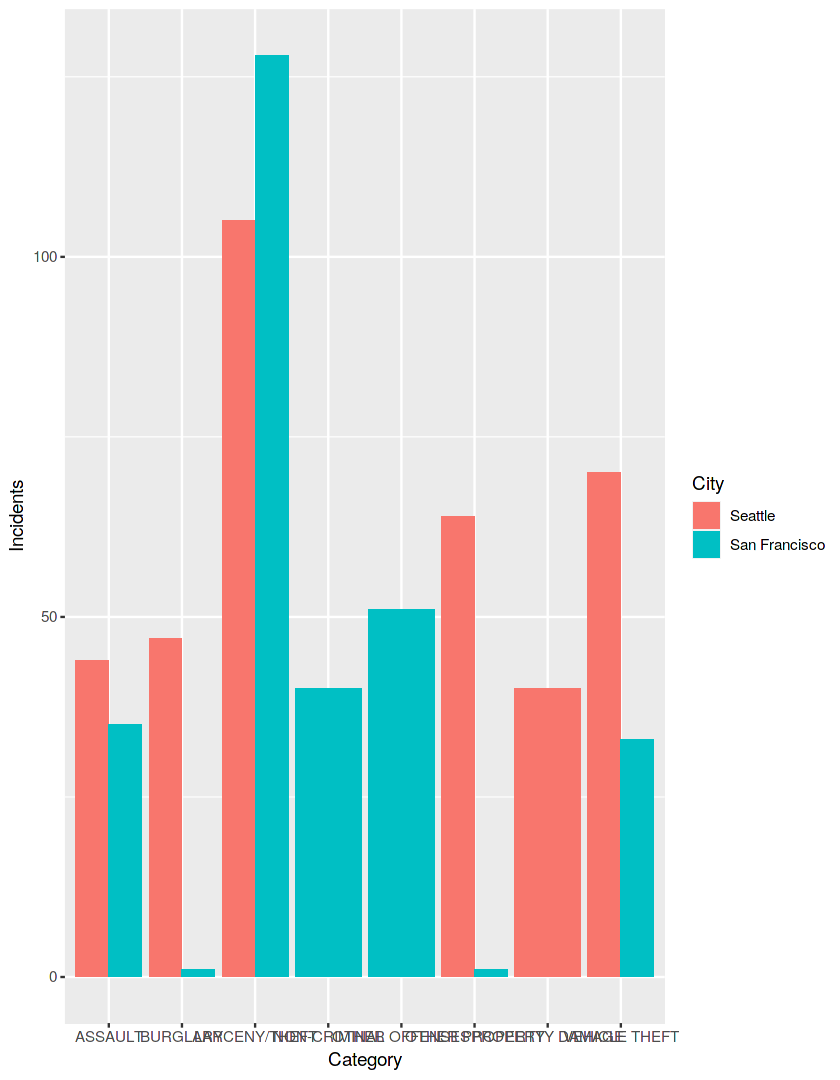

In [6]:
ggplot(grouped_bar_data, aes(fill=City, y=Incidents, x=Category)) + geom_bar(position="dodge", stat="identity")

The first observation to make is that while Seattle and San Francisco have similar problems, such as Assault and Larceny, there are some types of crime that are more prominent in one city than the other. For example, Property Damage is more dominant in Seattle than in San Francisco. It is difficult, however, to make converse statements about San Francisco since "Non-Criminal" and "Other Offences" categories are too ambiguous to single out as prominent activities.

Having identified the types of crimes taking place, understanding when they occur can be helpful in prevention. As there are many facets of time, it may be important to look at activity on specific days and/or times of day to gain insights. The Incident by the Time of day graphs for each day of the week is plotted for each city for comparison.


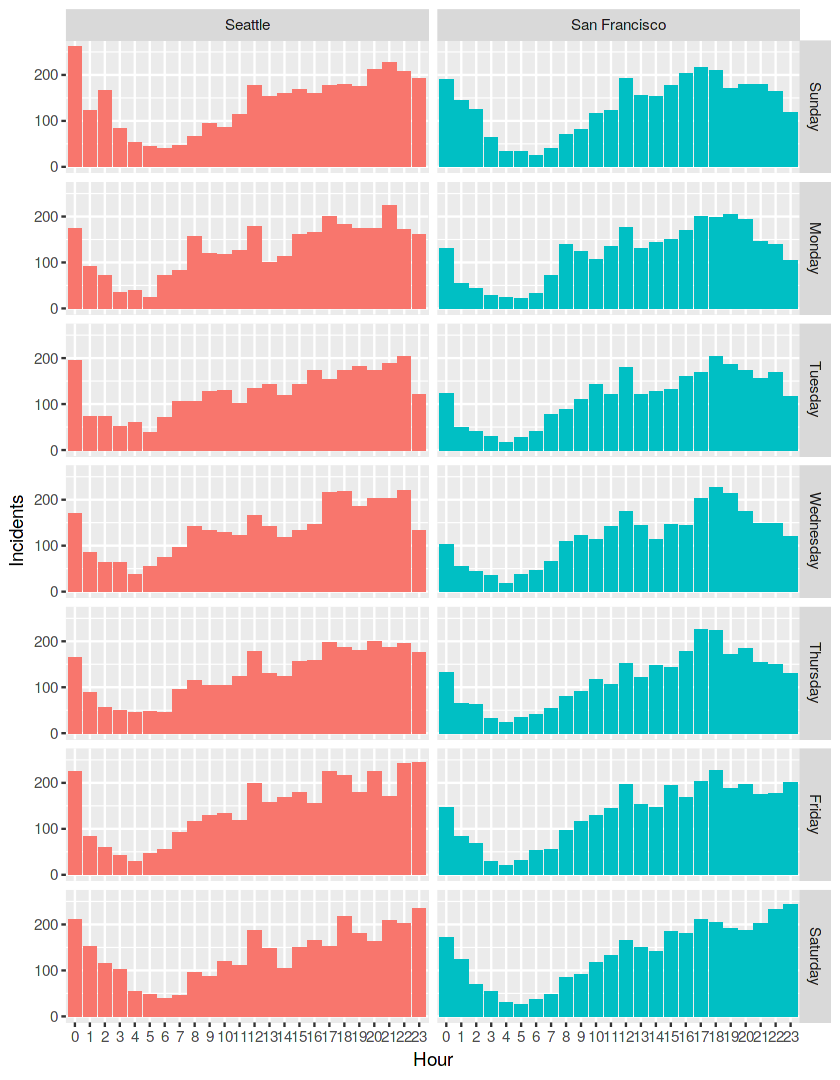

In [7]:
ggplot(grouped_bar_data, aes(fill=City,y=Incidents, x=Hour)) + facet_grid(DayOfWeek ~ City) + geom_bar(stat='identity', show.legend = FALSE)

Looking at the activity across the days of the week, it is observed that the hourly pattern is very similar and does not provide much insight, save increases in activity between 10pm-12am (hours 22 and 23) on Fridays and Saturdays. The intuitive pattern of reduced activity just after the early hours of the morning, is met with the slightly alarming rise and maintainence of activity throughout the rest of the day.

A more curious insight, however, is a noticeable spike in activity around 12pm and 1pm (hour 12) that goes down slightly afterwards. Zooming in near this specific period (2 hours before and after) and splitting the data by crime type can give us more insight into why this spike occurs across both cities.

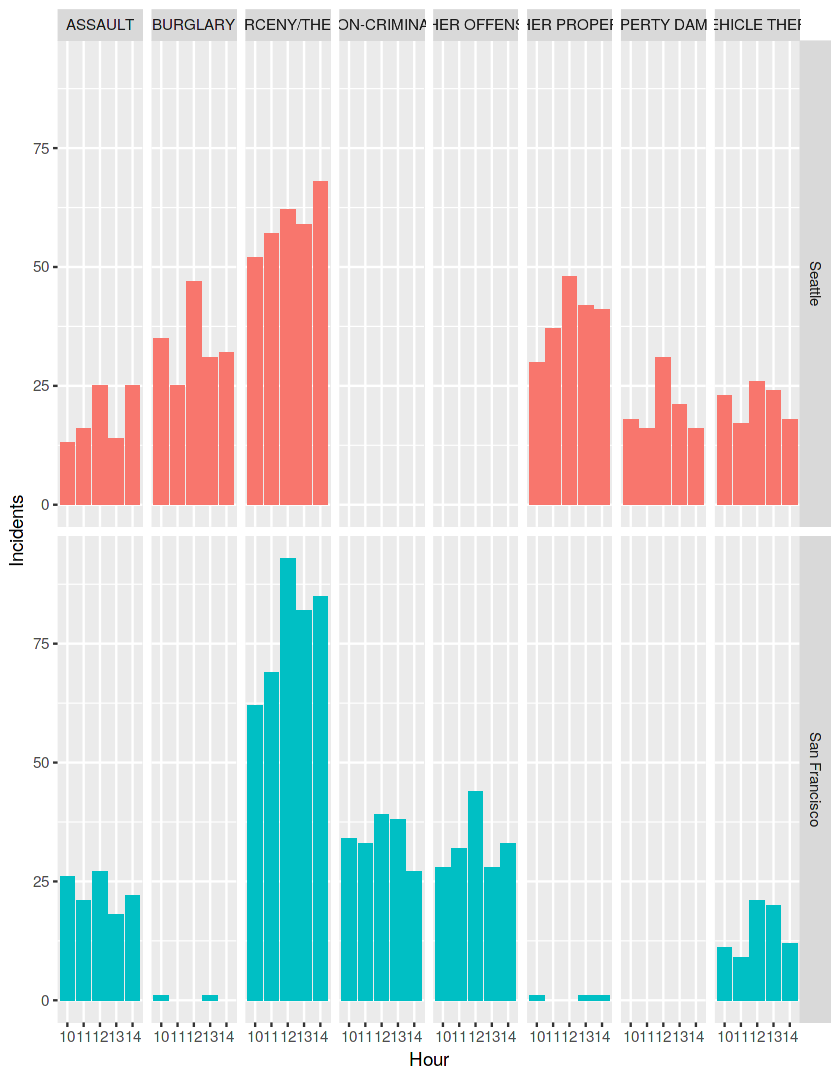

In [8]:
time_filtered <- grouped_bar_data[as.integer(as.character(grouped_bar_data$Hour)) %in% 10:14,]
ggplot(time_filtered, aes(fill=City,y=Incidents, x=Hour)) + facet_grid(City ~ Category) + geom_bar(position="dodge",stat='identity', show.legend = FALSE)

Looking at each crime type individually, there is no distinctive pattern in one crime type that suggests a certain type of crime is taking place more often than the others at this time. This suggests that the spike is just characteristic of criminal activity and nothing more. 